# Cluster Quality: Silhouette Scores vs. Annotation Results
Does Silhouette Coefficient give us a good indication of which clusters humans annotated as coherent?

In [1]:
from collections import defaultdict
import itertools
import joblib
import json
from pathlib import Path

import dvc.api
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from smart_open import open 
import sklearn

import ihop
from ihop.community2vec import GensimCommunity2Vec
import ihop.clustering as ic

sns.set_palette("Dark2")

In [2]:
DATA_PATH = Path("../data")
KMEANS_ANNOTATED_DATA_PATH = DATA_PATH / "kmeans_annotation_task_data"
KMEANS_COHERENCE_CSV = KMEANS_ANNOTATED_DATA_PATH / "Coherence Task March 2022_July 2021 All - both months raw labels.csv"
AGGLOM_ANNOTATED_DATA_PATH = DATA_PATH / "average_agglomerative_annotation_task"
AGGLOM_COHERENCE_CSV = AGGLOM_ANNOTATED_DATA_PATH / "Agglomerative Coherence Task March 2022_July 2021 All - both months raw coherence ratings.csv"
MONTHS = ["2021-07", "2022-03"]

# For kmeans++ models, we're checking out community2vec models from before the 
# user profile fix, so we have to read them directly from DVC, not the data folder.
# The agglomerative models for annotation were produced after that fix.
DVC_C2V_ROOT = "data/community2vec"
DVC_REPO = "../"
KMEANS_GIT_COMMIT ="149c208438c641ca2bd3ee8956bd2e6d2b936e9d"
AGGLOM_GIT_COMMIT = "4d0d46c0b3a509369f051949db0d3fef8ca56ff5"

EXPERIMENT_LIST = [
    ("kmeans", KMEANS_GIT_COMMIT, KMEANS_ANNOTATED_DATA_PATH, KMEANS_COHERENCE_CSV), 
    ("agglomerative", AGGLOM_GIT_COMMIT, AGGLOM_ANNOTATED_DATA_PATH, AGGLOM_COHERENCE_CSV)
]


In [3]:
# Collect the metrics for the different kinds of models
coherence_dfs = []
silhouette_dfs = []

for (model_type, git_commit, annotated_data_path, coherence_csv) in EXPERIMENT_LIST:
    subreddit_datapoints = {"month":[], "model_id":[], "cluster_id":[], "subreddit":[], "silhouette_coefficient":[], "model_type":[]}

    coherence_df = pd.read_csv(coherence_csv)
    coherence_dfs.append(coherence_df)

    for m in MONTHS:
        c2v_url = dvc.api.get_url(f"{DVC_C2V_ROOT}/RC_{m}/best_model/word2vec.pickle", repo=DVC_REPO, rev=git_commit)
        print("Loading", m, "community2vec model from DVC:", c2v_url)
        c2v_model = gensim.models.Word2Vec.load(c2v_url)
        embeddings = c2v_model.wv.get_normed_vectors()
        subreddit_index = c2v_model.wv.index_to_key
        cluster_model_path = annotated_data_path / f"RC_{m}" / f"{model_type}_model" / "sklearn_cluster_model.joblib"
        cluster_model = joblib.load(cluster_model_path)

        silhouette_scores = sklearn.metrics.cluster.silhouette_samples(embeddings, cluster_model.labels_)
        subreddit_datapoints["month"].extend([m] * len(subreddit_index))
        subreddit_datapoints["model_id"].extend([f"{m}_{model_type}_clusters"] * len(subreddit_index))
        subreddit_datapoints["cluster_id"].extend(cluster_model.labels_)
        subreddit_datapoints["subreddit"].extend(subreddit_index)
        subreddit_datapoints["silhouette_coefficient"].extend(silhouette_scores)
        subreddit_datapoints["model_type"].extend([model_type] * len(subreddit_index))

    silhouette_df = pd.DataFrame(data=subreddit_datapoints)
    silhouette_dfs.append(silhouette_df)

coherence_df = pd.concat(coherence_dfs, ignore_index=True)
silhouette_df = pd.concat(silhouette_dfs, ignore_index=True)



Loading 2021-07 community2vec model from DVC: s3://ihopmeag/redditdvccache/b0/7a1b7ed92770b861fa31de093547d7
Loading 2022-03 community2vec model from DVC: s3://ihopmeag/redditdvccache/d1/14cf04e2c4af3df6d98a6b72208289
Loading 2021-07 community2vec model from DVC: s3://ihopmeag/redditdvccache/33/de6ad49a48b8691ccfabffae214fac
Loading 2022-03 community2vec model from DVC: s3://ihopmeag/redditdvccache/73/339c9fe05bc164ef502612f55c6ca8


In [4]:
print(silhouette_df.shape)
display(silhouette_df.sort_values(by="silhouette_coefficient", ascending=False))

(40000, 6)


,month,model_id,cluster_id,subreddit,silhouette_coefficient,model_type
33166,2022-03,2022-03_agglomerative_clusters,64,BotTown2,0.485969,agglomerative
34712,2022-03,2022-03_agglomerative_clusters,64,xrptrader,0.467434,agglomerative
37108,2022-03,2022-03_agglomerative_clusters,64,OzBargainNew,0.466233,agglomerative
31586,2022-03,2022-03_agglomerative_clusters,64,SubredditSummaryBot,0.432775,agglomerative
26083,2021-07,2021-07_agglomerative_clusters,97,OzBargainNew,0.425345,agglomerative
...,...,...,...,...,...,...
21833,2021-07,2021-07_agglomerative_clusters,6,hingeapp,-0.251849,agglomerative
36293,2022-03,2022-03_agglomerative_clusters,96,Yankee_Clickers,-0.280684,agglomerative
20107,2021-07,2021-07_agglomerative_clusters,6,Tinder,-0.283284,agglomerative
24776,2021-07,2021-07_agglomerative_clusters,47,aforismiecitazioni,-0.312714,agglomerative


<AxesSubplot:xlabel='silhouette_coefficient', ylabel='Count'>

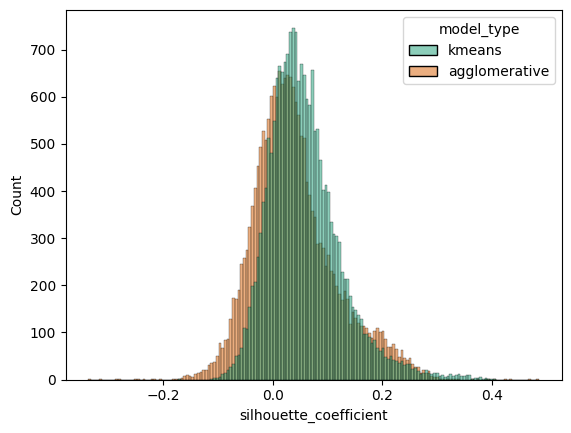

In [5]:
sns.histplot(data=silhouette_df, x="silhouette_coefficient", hue="model_type")

In [6]:
# Get cluster level silhouette scores for each model
cluster_silhouette_df = silhouette_df.groupby(by=["model_id", "cluster_id"])["silhouette_coefficient"].mean().reset_index()
display(cluster_silhouette_df)

,model_id,cluster_id,silhouette_coefficient
0,2021-07_agglomerative_clusters,0,0.010082
1,2021-07_agglomerative_clusters,1,0.020041
2,2021-07_agglomerative_clusters,2,0.082466
3,2021-07_agglomerative_clusters,3,0.024462
4,2021-07_agglomerative_clusters,4,0.018234
...,...,...,...
395,2022-03_kmeans_clusters,95,0.033188
396,2022-03_kmeans_clusters,96,0.034214
397,2022-03_kmeans_clusters,97,0.012300
398,2022-03_kmeans_clusters,98,0.107910


<AxesSubplot:xlabel='silhouette_coefficient', ylabel='model_id'>

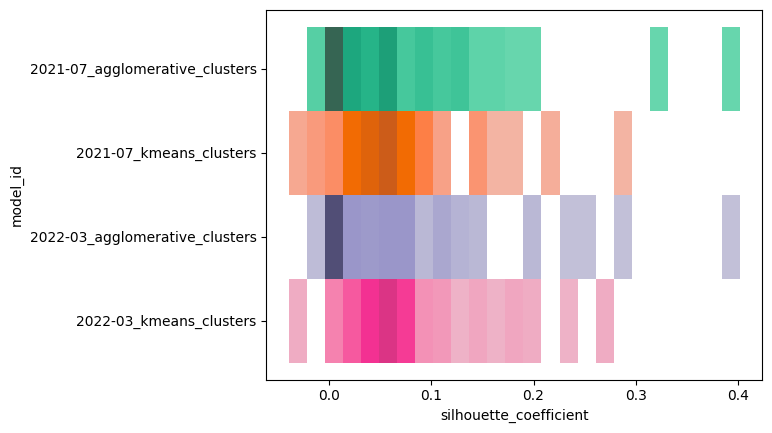

In [7]:
sns.histplot(data=cluster_silhouette_df, x="silhouette_coefficient", y="model_id", hue="model_id", legend=False)

In [8]:
coherence_df["Coherence Score"] = coherence_df['Ryan Coherence'] + coherence_df['Rebecca Coherence'] + coherence_df['Ethan Coherence']
print(coherence_df.shape)
display(coherence_df)

(400, 6)


,Model ID,Cluster ID,Ryan Coherence,Rebecca Coherence,Ethan Coherence,Coherence Score
0,2021-07_kmeans_clusters,0,1,1,1,3
1,2021-07_kmeans_clusters,1,1,1,1,3
2,2021-07_kmeans_clusters,2,1,1,0,2
3,2021-07_kmeans_clusters,3,0,1,0,1
4,2021-07_kmeans_clusters,4,1,1,0,2
...,...,...,...,...,...,...
395,2021-07_agglomerative_clusters,95,1,0,0,1
396,2021-07_agglomerative_clusters,96,1,1,1,3
397,2021-07_agglomerative_clusters,97,0,0,0,0
398,2021-07_agglomerative_clusters,98,1,1,1,3


In [9]:
joined_df = pd.merge(coherence_df, cluster_silhouette_df, how="left", left_on=["Model ID", "Cluster ID"], right_on=["model_id", "cluster_id"])
display(joined_df)

,Model ID,Cluster ID,Ryan Coherence,Rebecca Coherence,Ethan Coherence,Coherence Score,model_id,cluster_id,silhouette_coefficient
0,2021-07_kmeans_clusters,0,1,1,1,3,2021-07_kmeans_clusters,0,0.107269
1,2021-07_kmeans_clusters,1,1,1,1,3,2021-07_kmeans_clusters,1,0.008824
2,2021-07_kmeans_clusters,2,1,1,0,2,2021-07_kmeans_clusters,2,0.022307
3,2021-07_kmeans_clusters,3,0,1,0,1,2021-07_kmeans_clusters,3,0.015974
4,2021-07_kmeans_clusters,4,1,1,0,2,2021-07_kmeans_clusters,4,0.037621
...,...,...,...,...,...,...,...,...,...
395,2021-07_agglomerative_clusters,95,1,0,0,1,2021-07_agglomerative_clusters,95,0.000000
396,2021-07_agglomerative_clusters,96,1,1,1,3,2021-07_agglomerative_clusters,96,0.061591
397,2021-07_agglomerative_clusters,97,0,0,0,0,2021-07_agglomerative_clusters,97,0.322481
398,2021-07_agglomerative_clusters,98,1,1,1,3,2021-07_agglomerative_clusters,98,0.121285


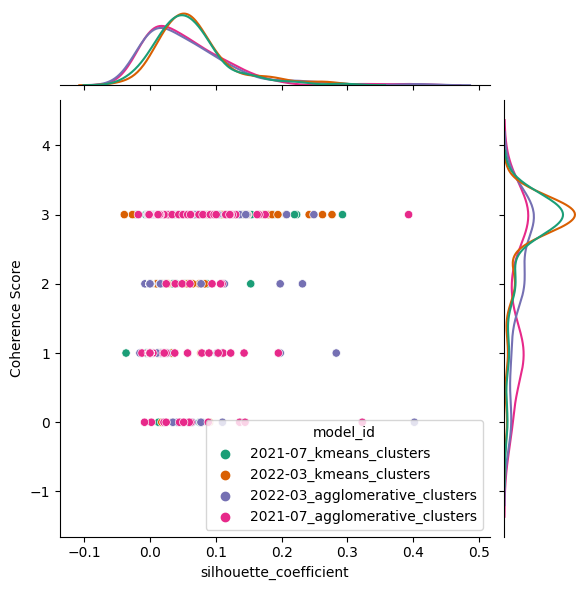

In [10]:
sns.jointplot(data=joined_df, x="silhouette_coefficient", y="Coherence Score", hue="model_id", marginal_kws={"fill":False})

(-0.2, 0.5)

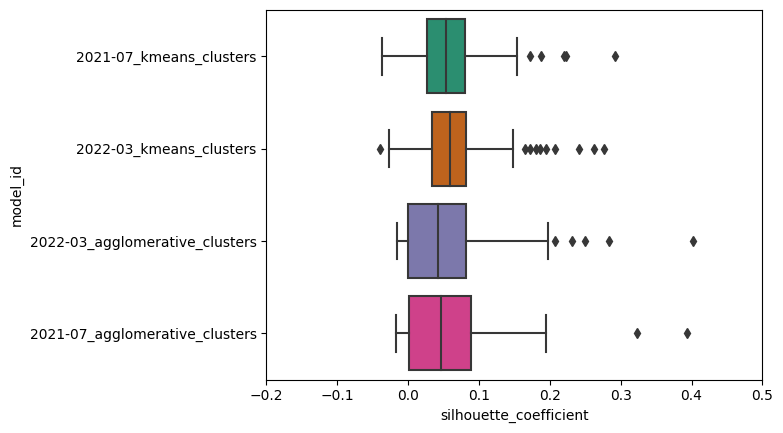

In [33]:
ax = sns.boxplot(data=joined_df, y="model_id", x="silhouette_coefficient")
ax.set_xlim(-0.2, 0.5)
#plt.xticks(rotation=60)

<AxesSubplot:xlabel='Coherence Score', ylabel='count'>

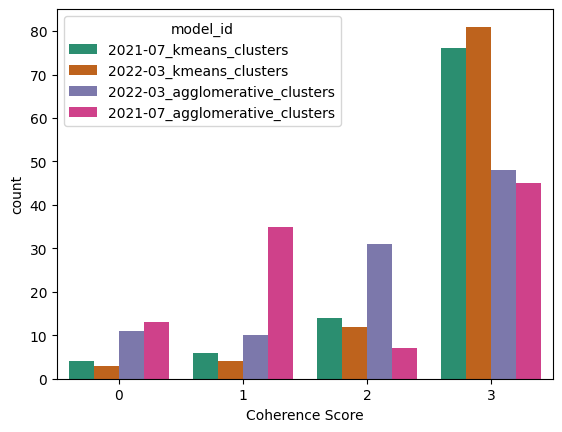

In [34]:
sns.countplot(data=joined_df, x="Coherence Score", hue="model_id")

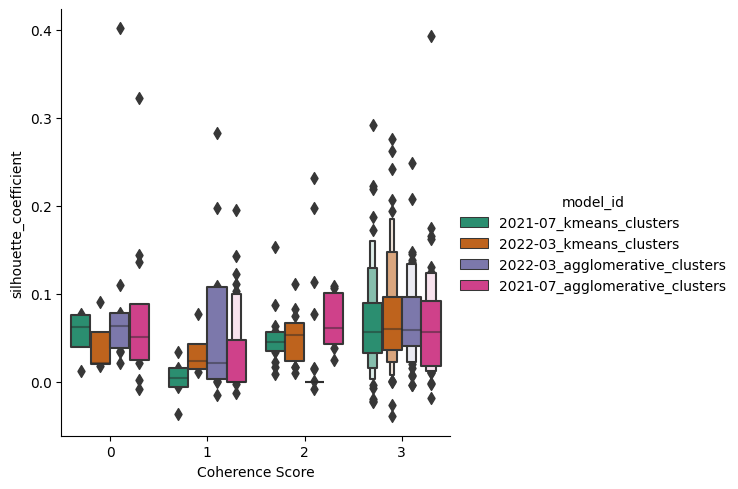

In [25]:
sns.catplot(data=joined_df, x="Coherence Score", y="silhouette_coefficient", hue="model_id", kind="boxen")
